# Model Training
Trains a model on past data.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

### SET PARAMETERS:


In [666]:
TICKER="TDOC"
DATA_INTERVAL_MINUTES = 15   # (Set to 5 or 15)
DATA_AFTER_HOURS = False

DAYS_PREDICT = 3
# ISSUE: If stock goes down slowly, less than 'DOWN_PCTS_PREDICT' then won't sell but after few periods will be very down 
#  example: DOWN_PCTS_PREDICT=5% then down 4% and down 3% and down 1%... and never sell
DOWN_PCTS_PREDICT= [3.0]
UP_PCTS_PREDICT= [3.0]

signal_avg= [
    2, 
    3, 
    5, 
    8, 
    13, 
    21, 
    34, 
    55, 
    89, 
    144, 
    233, 
    377, 
    610, 
    987, 
    1597, 
    2584]

PREDICT_UP = False
if PREDICT_UP:
    INDEX_KEEP= 2
    INDEX_REMOVE_A= 0
    INDEX_REMOVE_B= 1
else:
    INDEX_KEEP= 0
    INDEX_REMOVE_A= 1
    INDEX_REMOVE_B= 2

TRAIN_SPLIT = 0.9

# TODO: When executing only using 33-38% GPU - Try different BATCH_SIZE see if parallelism increases? Learning decreases because less batches?
BATCH_SIZE= 32

HIDDEN_UNITS=12

TRAINING_THRESHOLD = 0.7

#### DOWNLOAD DATA (DON'T EXECUTE IF ALREADY LOADED)

In [608]:
import sys
sys.path.append('..\\..')

from datetime import datetime

import settings
import apis.tiingo_api as tiingo

secret_key= settings.get_secret("tiingo-key")

### TRAINING DATA
csv_data2017= tiingo.download_ticker(secret_key, TICKER, datetime(2017, 1, 1), datetime(2018,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2018= tiingo.download_ticker(secret_key, TICKER, datetime(2018, 1, 1), datetime(2019,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2019= tiingo.download_ticker(secret_key, TICKER, datetime(2019, 1, 1), datetime(2020,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2020= tiingo.download_ticker(secret_key, TICKER, datetime(2020, 1, 1), datetime(2021,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2021= tiingo.download_ticker(secret_key, TICKER, datetime(2021, 1, 1), datetime(2022,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2022= tiingo.download_ticker(secret_key, TICKER, datetime(2022, 1, 1), datetime(2023,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 1, 1), datetime(2024,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
# csv_data2024= tiingo.download_ticker(secret_key, TICKER, datetime(2024, 1, 1), datetime(2024,2,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)

Retrieving TDOC from 2017-01-01 00:00:00 to 2018-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=psst_it_s_a_secret&startDate=2017-01-01&endDate=2018-01-01&resampleFreq=15min&afterHours=false&format=csv


Retrieving TDOC from 2018-01-01 00:00:00 to 2019-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=psst_it_s_a_secret&startDate=2018-01-01&endDate=2019-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TDOC from 2019-01-01 00:00:00 to 2020-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=psst_it_s_a_secret&startDate=2019-01-01&endDate=2020-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TDOC from 2020-01-01 00:00:00 to 2021-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=psst_it_s_a_secret&startDate=2020-01-01&endDate=2021-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TDOC from 2021-01-01 00:00:00 to 2022-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC/prices?token=psst_it_s_a_secret&startDate=2021-01-01&endDate=2022-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TDOC from 2022-01-01 00:00:00 to 2023-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TDOC

In [610]:
import io
import pandas as pd

# ### TRAINING DATA
df2017 = pd.read_csv(io.StringIO(csv_data2017))
df2018 = pd.read_csv(io.StringIO(csv_data2018))
df2019 = pd.read_csv(io.StringIO(csv_data2019))
df2020 = pd.read_csv(io.StringIO(csv_data2020))
df2021 = pd.read_csv(io.StringIO(csv_data2021))
df2022 = pd.read_csv(io.StringIO(csv_data2022))
df2023 = pd.read_csv(io.StringIO(csv_data2023))
# df2024 = pd.read_csv(io.StringIO(csv_data2024))

# if not df2017.empty:
#     print("Concatenating from 2017")
#     df = pd.concat([df2017, df2018, df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
# elif not df2018.empty:
#     print("Concatenating from 2018")
#     df = pd.concat([df2018, df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
# el
if not df2019.empty:
    print("Concatenating from 2019")
    df = pd.concat([df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
elif not df2020.empty:
    print("Concatenating from 2020")
    df = pd.concat([df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
else:
    print("Concatenating from 2021")
    df = pd.concat([df2021, df2022, df2023], axis=0, ignore_index=True)

# if not df2024.empty:
#     print("Concatenating from 2024")
#     df = pd.concat([df, df2024], axis=0, ignore_index=True)

Concatenating from 2019


In [611]:
# Validates that data has been concatenated correctly = ordered ascending
if df["date"].is_monotonic_increasing and df["date"].is_unique:
    print("Correct: DataFrame is in ascending order.")
else:
    print("Error: DataFrame is not in ascending order.")


Correct: DataFrame is in ascending order.


In [612]:
# Displays first and last element in the data
print(f"Data first:\n{df[['date', 'close']][:5]}")
print(f"Data last:\n{df[['date', 'close']][-5:]}")

Data first:
                        date   close
0  2019-01-02 09:30:00-05:00  48.335
1  2019-01-02 09:45:00-05:00  48.050
2  2019-01-02 10:00:00-05:00  48.060
3  2019-01-02 10:15:00-05:00  47.580
4  2019-01-02 10:30:00-05:00  47.600
Data last:
                            date   close
33795  2023-12-29 14:45:00-05:00  21.635
33796  2023-12-29 15:00:00-05:00  21.585
33797  2023-12-29 15:15:00-05:00  21.575
33798  2023-12-29 15:30:00-05:00  21.595
33799  2023-12-29 15:45:00-05:00  21.550


In [667]:

# If quotes every 15min there 26 per day if quotes every 5min there are 78 per day
TICKS_IN_DAY = 26 if DATA_INTERVAL_MINUTES == 15 else 78
# How many data ticks are inspecting to determine the if up or down by percentage 
TICKS_PREDICT= TICKS_IN_DAY * DAYS_PREDICT
REACH_PCT= 0.95

import classifiers.up_down_classifier as udc
import classifiers.ewa_classifier as ec

alpha= ec.calculate_ewa_alpha(TICKS_PREDICT, REACH_PCT)
print(f"alpha: {alpha:.4f} for window: {TICKS_PREDICT} and reach: {REACH_PCT}")

classes_calc = udc.UpsDownsClassifier(TICKS_PREDICT, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

close_prices = df['close'].astype(float).tolist()
input_data= ec.calculate_ewas(close_prices, alpha)

classes= classes_calc.classify(input_data)
print(f"Check correct 'nan' point (window={TICKS_PREDICT}): {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]}")
print(f"prices vs input_data: {[(p, c) for p, c in zip(close_prices[2650:3000], input_data[2650:3000])]}")
print(f"input_data vs classes: {[(p, c) for p, c in zip(input_data[2650:3000], classes[2650:3000])]}")


alpha: 0.0377 for window: 78 and reach: 0.95


Check correct 'nan' point (window=78): [1, nan]
prices vs input_data: [(59.575, 60.857121221861995), (59.87, 60.81992784243145), (60.74, 60.816916270494005), (60.235, 60.79499046020246), (60.64, 60.78915063134785), (60.5, 60.77825583048032), (60.54, 60.7692786761974), (59.73, 60.73012007512409), (59.945, 60.700537823009654), (60.1, 60.67791037805263), (60.025, 60.65330960675197), (60.125, 60.6334036223343), (60.18, 60.61631999310297), (60.47, 60.610806855606555), (60.69, 60.613790745125385), (60.79, 60.62043006918263), (60.89, 60.63058709599748), (61.065, 60.64695518089957), (61.08, 60.66327171823108), (60.895, 60.67200292339387), (60.865, 60.67927478964517), (60.95, 60.689475345815104), (60.975, 60.700233524815495), (61.02, 60.71228188886371), (61.17, 60.72952808214037), (61.17, 60.7461244624092), (61.26, 60.7654865908149), (61.26, 60.78411918066706), (61.26, 60.802049719981966), (61.26, 60.81930466106499), (61.26, 60.83590945953479), (61.26, 60.85188861187707), (61.26, 60.86726569158

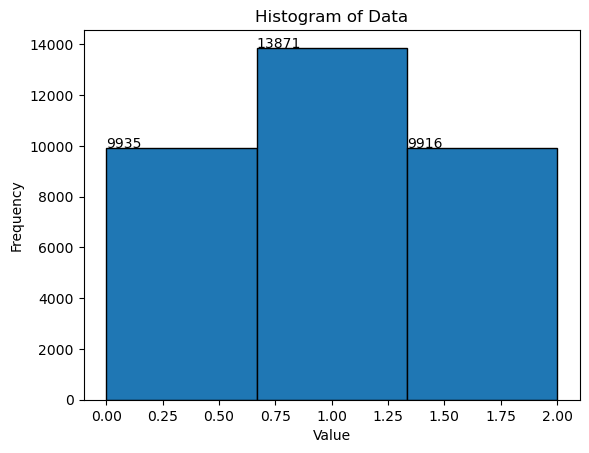

In [698]:
import matplotlib.pyplot as plt

# Create a histogram
hist_values, bin_edges, _ = plt.hist(classes, bins=3, edgecolor='black')

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display frequency on top of each bar
for value, edge in zip(hist_values, bin_edges[:-1]):
    plt.text(float(edge), float(value), str(int(value)), color='black')
    
# Show the histogram
plt.show()


In [669]:
# Show percentages of each class value
import utils.list_utils as lu

lu.display_frequency_classes(classes, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

Total: 33800
 29.39%   9935 times -3.0% change (0)
 41.04%  13871 times   0% change (1)
 29.34%   9916 times 3.0% change (2)
  0.23%     78 times   0% change (nan)


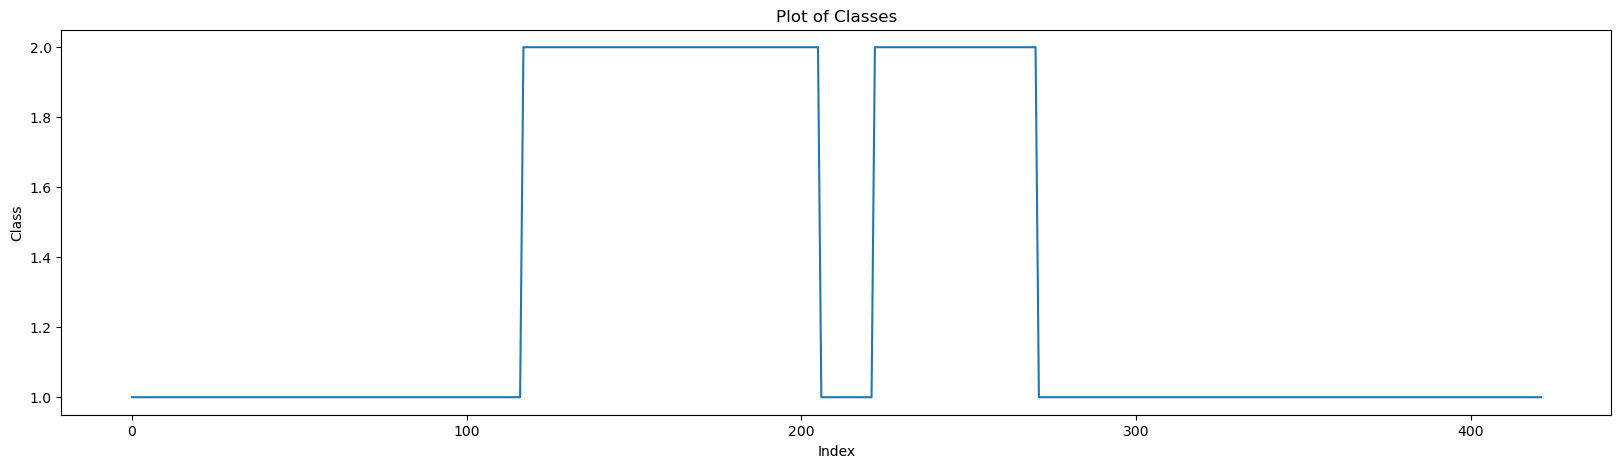

In [670]:
# Display classes value changes over time (last 500 ticks)
graph_ticks = 500
x = range(len(classes[-graph_ticks:]))

plt.figure(figsize=(20,5))
plt.plot(x, classes[-graph_ticks:], linestyle='-')


plt.xlabel('Index')
plt.ylabel('Class')
plt.title('Plot of Classes')

plt.show()

In [671]:

# Calculate the signals as input for the neural network as proportions
import preprocessing.proportions_calc as proportions

signals_calculator = proportions.ProportionsCalc(signal_avg)

proportions_avg = signals_calculator.calculate(close_prices)


In [672]:
print(f"Prices length: {len(close_prices)}")
print(f"Proportions length: {len(proportions_avg[-1])}")

print(f"Last 10 close: {close_prices[-10:]}")
print(f"Last 10 proportions(avg={signal_avg[0]}): {proportions_avg[0][-10:]}")

print(f"Proportions avgs: Count: {len(signal_avg)} Max: {signal_avg[-1]}")
# At the end of the data, when less ticks than necessary no possible to predict so "nan" 
print(f"Classes last non-nan: {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]} len: {len(classes)}")
print(f"Proportions first non-nan(avg={signal_avg[-1]}): {proportions_avg[-1][signal_avg[-1]-2:signal_avg[-1]]} len: {len(proportions_avg[-1])}")
print(f"Proportions (avg={signal_avg[0]}) Min: {min(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT])}")
print(f"Proportions (avg={signal_avg[-1]}) Min: {min(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT])}")

Prices length: 33800
Proportions length: 33800
Last 10 close: [21.67, 21.675, 21.595, 21.61, 21.605, 21.635, 21.585, 21.575, 21.595, 21.55]
Last 10 proportions(avg=2): [0.0010383017997877535, 0.00011534025381319715, -0.0018522806204491493, 0.00034706154564553696, -0.00011571395503825548, 0.0006933210076910923, -0.0011582117210380317, -0.00023174971024826613, 0.0004630701551930645, -0.0010440835266173844]
Proportions avgs: Count: 16 Max: 2584
Classes last non-nan: [1, nan] len: 33800
Proportions first non-nan(avg=2584): [nan, 0.04775961289436253] len: 33800
Proportions (avg=2) Min: -0.4463711723904172 Max: 0.0804459444903232
Proportions (avg=2584) Min: -1.5557672273632965 Max: 0.4178473651851586


In [673]:
# Removing the "nan" from the proportions
#   At the beging first signal_avg[-1] are "nan" (need previous values for first avg.)
#   At the end decided not predict if period to predict is shorter
targets = classes[signal_avg[-1]-1:-TICKS_PREDICT]
inputs = []
for proportion in proportions_avg:
    proportion_cut= proportion[signal_avg[-1]-1:-TICKS_PREDICT]
    print(proportion_cut[:2])
    inputs.append(proportion_cut)

print(f"First target: {targets[0]} and last target: {targets[-1]}")
print(f"Classes: {len(classes)} after cut to targets: {len(targets)}")
print(f"Inputs len: {len(inputs[len(signal_avg)-1])}")
print(f"Distinct targets: {list(set(targets))}")


[-0.00043901660281407115, 0.0017499204581566882]
[-0.0022349936143053295, 0.0020415738678529736]
[-0.0025862068965511417, 0.0011613108495074121]
[-0.0007882343550470457, 0.001978603245304667]
[0.00865753020925677, 0.009226853324851217]
[0.017070333880679356, 0.018972622456555562]
[0.02544652918638799, 0.027060601523460872]
[0.030475734355044568, 0.03333670783559409]
[0.027352662619999964, 0.03008647717238506]
[0.039117377075351595, 0.04199864336974609]
[0.0382853995033948, 0.041647492417920776]
[0.04111871635652622, 0.044214291199927404]
[0.07357643468793937, 0.07648391168508817]
[0.09170194327017571, 0.0947180511782031]
[0.06392903440438866, 0.06726794054474329]
[0.04775961289436253, 0.05100287975933675]
First target: 1 and last target: 1
Classes: 33800 after cut to targets: 31139
Inputs len: 31139
Distinct targets: [0, 1, 2]


In [674]:
from collections import Counter

print("Train data: 'nan' removed from begining and end")
lu.display_frequency_classes(targets, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

targets_frequency = Counter(targets)
print("VALIDATE removing should be POSITIVE?")
count_remove_a= targets_frequency[INDEX_REMOVE_A] - targets_frequency[INDEX_KEEP] + targets_frequency[INDEX_KEEP] //2
count_remove_b= targets_frequency[INDEX_REMOVE_B] - targets_frequency[INDEX_KEEP] + targets_frequency[INDEX_KEEP] //2
print(f"Removing {INDEX_REMOVE_A}: {count_remove_a}")
print(f"Removing {INDEX_REMOVE_B}: {count_remove_b}")


Train data: 'nan' removed from begining and end
Total: 31139
 30.05%   9357 times -3.0% change (0)
 41.29%  12858 times   0% change (1)
 28.66%   8924 times 3.0% change (2)
VALIDATE removing should be POSITIVE?
Removing 1: 8179
Removing 2: 4245


In [675]:
###################
##### SET PARAMETERS
###################
# DECISION SET: REMOVING?
indexes_remove_a= []
# 2024-03-01 Do not remove anything
# if count_remove_a > 0:
#     indexes_remove_a = get_indexes_value(targets, index_remove_a, count_remove_a)

# DECISION SET: REMOVING?
indexes_remove_b= []
# 2024-03-01 Do not remove anything
# if count_remove_b > 0:
#     indexes_remove_b = get_indexes_value(targets, index_remove_b, count_remove_b)

indexes_remove= indexes_remove_a + indexes_remove_b
targets_clean= lu.remove_indexes(targets, indexes_remove)

lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)
print(f"Targets len: {len(targets)} Targets clean: {len(targets_clean)} Difference: {len(targets)-len(targets_clean)}")

inputs_clean = [lu.remove_indexes(input, indexes_remove) for input in inputs]    
print(f"targets_clean positions(Keep={INDEX_KEEP})(First:{targets_clean.index(INDEX_KEEP)},Last:-{targets_clean[::-1].index(INDEX_KEEP)})")


Total: 31139
 30.05%   9357 times -3.0% change (0)
 41.29%  12858 times   0% change (1)
 28.66%   8924 times 3.0% change (2)
Targets len: 31139 Targets clean: 31139 Difference: 0
targets_clean positions(Keep=0)(First:42,Last:-871)


In [676]:
# Sets 'index_keep' as target = 1 and rest of indexes to target=0
targets_binary= lu.convert_binary(targets_clean, INDEX_KEEP)
print(f"targets_binary First {targets_binary.index(True)} and Last(counting from end) {targets_binary[::-1].index(True)} position with True")
print(f"targets_binary len: {len(targets_binary)} Input clean[0]: {len(inputs_clean[0])} Input clean[-1]: {len(inputs_clean[-1])}")

targets_binary First 42 and Last(counting from end) 871 position with True
targets_binary len: 31139 Input clean[0]: 31139 Input clean[-1]: 31139


In [677]:
import torch

inputs_tensor = torch.Tensor(inputs_clean)
print(f"inputs_tensor: {inputs_tensor.size()}")
inputs_tensor = inputs_tensor.T
print(f"inputs_tensor: {inputs_tensor.size()}")
targets_tensor = torch.Tensor(targets_binary)
print(f"inputs_clean len0 x len1: {len(inputs_clean)} x {len(inputs_clean[0])} -> inputs_tensor.shape: {inputs_tensor.shape}")
print(f"targets_binary.shape: {len(targets_binary)} -> targets_tensor.shape: {targets_tensor.shape}")
print(f"inputs_tensor: {inputs_tensor}")
print(f"targets_tensor: {targets_tensor}")

inputs_tensor: torch.Size([16, 31139])
inputs_tensor: torch.Size([31139, 16])
inputs_clean len0 x len1: 16 x 31139 -> inputs_tensor.shape: torch.Size([31139, 16])
targets_binary.shape: 31139 -> targets_tensor.shape: torch.Size([31139])
inputs_tensor: tensor([[-0.0004, -0.0022, -0.0026,  ...,  0.0917,  0.0639,  0.0478],
        [ 0.0017,  0.0020,  0.0012,  ...,  0.0947,  0.0673,  0.0510],
        [-0.0004,  0.0007,  0.0002,  ...,  0.0939,  0.0667,  0.0502],
        ...,
        [ 0.0025,  0.0028,  0.0041,  ...,  0.1579,  0.1668,  0.1037],
        [ 0.0008,  0.0027,  0.0040,  ...,  0.1590,  0.1681,  0.1052],
        [-0.0030, -0.0034, -0.0021,  ...,  0.1538,  0.1630,  0.0999]])
targets_tensor: tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [678]:
#Shuffle tensors
torch.manual_seed(42) 
permutation = torch.randperm(inputs_tensor.size(0))
inputs_tensor_shuffle = inputs_tensor[permutation]

targets_tensor_shuffle = targets_tensor[permutation]

print(f"inputs_tensor.size(0): {inputs_tensor.size(0)}")
print(f"inputs_tensor.shape: {inputs_tensor.shape} -> inputs_tensor_shuffle.shape: {inputs_tensor_shuffle.shape}")
print(f"targets_tensor.shape: {targets_tensor.shape} -> targets_tensor_shuffle.shape: {targets_tensor_shuffle.shape}")

inputs_tensor.size(0): 31139
inputs_tensor.shape: torch.Size([31139, 16]) -> inputs_tensor_shuffle.shape: torch.Size([31139, 16])
targets_tensor.shape: torch.Size([31139]) -> targets_tensor_shuffle.shape: torch.Size([31139])


In [679]:

train_test_split= int(TRAIN_SPLIT * len(targets_tensor))
inputs_tensor_train, targets_tensor_train= inputs_tensor_shuffle[:train_test_split], targets_tensor_shuffle[:train_test_split]
inputs_tensor_test, targets_tensor_test= inputs_tensor_shuffle[train_test_split:], targets_tensor_shuffle[train_test_split:]


In [680]:
print("Training dataset frequencies:")
lu.display_frequency_values(targets_tensor_train.tolist())
print("Validation dataset frequencies:")
lu.display_frequency_values(targets_tensor_test.tolist())


Training dataset frequencies:
Total: 28025
 69.97%  19610 times (0.0)
 30.03%   8415 times (1.0)
Validation dataset frequencies:
Total: 3114
 69.75%   2172 times (0.0)
 30.25%    942 times (1.0)


In [681]:
from typing import Tuple
import torch
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(
        self,
        inputs,
        targets):
        
        self.inputs= inputs
        self.targets= targets

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        return self.inputs[index], self.targets[index]


In [682]:
from torch.utils.data import DataLoader


train_dataset= StockDataset(
  inputs_tensor_train,
  targets_tensor_train
)

print(f"train_dataset: {train_dataset[0]}")

train_dataloader= DataLoader(
  dataset=train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

train_input0, train_target0= next(iter(train_dataloader))
print(f"train_input0: {train_input0} train_target0: {train_target0}")


train_dataset: (tensor([ 0.0003, -0.0007, -0.0032, -0.0068, -0.0100, -0.0118, -0.0321, -0.0619,
        -0.0896, -0.1043, -0.0970, -0.0902, -0.0940, -0.0761, -0.1093, -0.1206]), tensor(0.))
train_input0: tensor([[ 3.3215e-04, -7.3812e-04, -3.1887e-03, -6.8091e-03, -9.9646e-03,
         -1.1799e-02, -3.2089e-02, -6.1929e-02, -8.9619e-02, -1.0426e-01,
         -9.7005e-02, -9.0209e-02, -9.4004e-02, -7.6088e-02, -1.0925e-01,
         -1.2056e-01],
        [ 9.8330e-03,  1.5764e-02,  1.9791e-02,  2.4465e-02,  3.0940e-02,
          3.9860e-02,  4.2623e-02,  3.3690e-02,  6.2940e-03,  3.4094e-02,
          6.9295e-02,  1.0923e-01,  1.5247e-01,  1.8318e-01,  1.5476e-01,
          1.5867e-01],
        [-3.1900e-03, -3.8457e-03, -3.4913e-03, -1.9517e-03,  1.6591e-03,
         -4.2010e-03, -2.0224e-03, -8.8779e-03, -2.2064e-02, -2.1051e-02,
         -2.4170e-02, -4.2289e-04,  3.1986e-02,  1.1310e-01,  1.8532e-01,
          2.1543e-01],
        [ 9.9580e-04,  6.2619e-03,  9.1398e-03,  9.0026e-03, 

In [683]:
test_dataset= StockDataset(
  inputs_tensor_test,
  targets_tensor_test
)

print(f"train_dataset: {train_dataset[0]}")

val_dataloader= DataLoader(
  dataset=test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

test_input0, test_target0= next(iter(val_dataloader))
print(f"test_input0: {train_input0} test_target0: {test_target0}")


train_dataset: (tensor([ 0.0003, -0.0007, -0.0032, -0.0068, -0.0100, -0.0118, -0.0321, -0.0619,
        -0.0896, -0.1043, -0.0970, -0.0902, -0.0940, -0.0761, -0.1093, -0.1206]), tensor(0.))
test_input0: tensor([[ 3.3215e-04, -7.3812e-04, -3.1887e-03, -6.8091e-03, -9.9646e-03,
         -1.1799e-02, -3.2089e-02, -6.1929e-02, -8.9619e-02, -1.0426e-01,
         -9.7005e-02, -9.0209e-02, -9.4004e-02, -7.6088e-02, -1.0925e-01,
         -1.2056e-01],
        [ 9.8330e-03,  1.5764e-02,  1.9791e-02,  2.4465e-02,  3.0940e-02,
          3.9860e-02,  4.2623e-02,  3.3690e-02,  6.2940e-03,  3.4094e-02,
          6.9295e-02,  1.0923e-01,  1.5247e-01,  1.8318e-01,  1.5476e-01,
          1.5867e-01],
        [-3.1900e-03, -3.8457e-03, -3.4913e-03, -1.9517e-03,  1.6591e-03,
         -4.2010e-03, -2.0224e-03, -8.8779e-03, -2.2064e-02, -2.1051e-02,
         -2.4170e-02, -4.2289e-04,  3.1986e-02,  1.1310e-01,  1.8532e-01,
          2.1543e-01],
        [ 9.9580e-04,  6.2619e-03,  9.1398e-03,  9.0026e-03,  

In [684]:
# EXECUTE FROM THIS STEP To CREATE A NETWORK WITH RANDOM WEIGHTS

import torch
from torch import nn

class StockModelBinaryV0(nn.Module):
  def __init__(self, input_features, hidden_units):
    """Initializes multi-class classification model"""
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units*16),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*16, out_features=hidden_units*8),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*8, out_features=hidden_units*4),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*4, out_features=hidden_units),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units, out_features=1)
    )

  def forward(self, x):
    # print("forward x: ",", ".join([str(num) for num in x.tolist()]))
    # Layers are defined inside the Sequencial NN and will be applied here.
    return self.linear_layer_stack(x)

# Create an instance of the model
model_0 = StockModelBinaryV0(
  input_features=len(signal_avg),
  hidden_units=HIDDEN_UNITS).to(device)


In [685]:
import torchmetrics

# loss_fn = nn.BCEWithLogitsLoss()

# Loss function for an imbalanced dataset (there many more 0's than 1's). Apply more weight to the less frequent class
num_ones = torch.count_nonzero(targets_tensor_train)
num_zeros = len(targets_tensor_train)-num_ones
pos_weight = num_zeros / num_ones
print(pos_weight)
# pos_weight_tensor = torch.tensor([pos_weight]).to(device)
# pos_weight_tensor = torch.tensor([1.5]).to(device)
print(f"Train negative: {num_zeros} positive: {num_ones} pos_weight: {pos_weight}")

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


tensor(2.3304)
Train negative: 19610 positive: 8415 pos_weight: 2.330362558364868


In [686]:
###################
##### SET PARAMETERS
###################
# PERFORMANCE_MEASURE="accu"
# performance_fn= torchmetrics.Accuracy(task='binary').to(device)
PERFORMANCE_MEASURE="prec"
performance_fn= torchmetrics.Precision(task='binary').to(device)
# PERFORMANCE_MEASURE="reca"
# performance_fn= torchmetrics.Recall(task='binary').to(device)
###################
##### SET PARAMETERS
###################

In [687]:
# Should you reset BEST PERFORMANCE
best_val_performance = 0
model_best = None

In [688]:
###################
##### SET PARAMETERS
###################
# DO: AFTER THIS CELL RUNS EXECUTE CELLS UNTIL SAVE STEP TO KEEP BEST RESULT IN CASE IT GOES DOWN
#    lr = 0.1 -> 0.03 -> 0.001
#    epochs 200 + 200 (lr=0.1) -> 100 (lr=0.03) -> 100 (lr=0.001)
# EXECUTE 0.1 x 200 for 2 TIMES (or 400 for 1 time)
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
# epochs=400
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.03)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.005)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0007)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0001)
# epochs=100
###Using Adam optimizer
# learning_rate = 0.005
# beta_1 = 0.9
# beta_2 = 0.999
# decay = 0.01
# optimizer = optim.Adam(params=model_0.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=1e-8, weight_decay=decay)
# epochs=2000

EPOCHS=1000
LEARNING_RATE= 0.1
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)

##### Using a StepLR Scheduler
# from torch.optim.lr_scheduler import StepLR
# gamma = 0.95
# scheduler = StepLR(optimizer, step_size=20, gamma=gamma)
## If continue optimization
# learning_rate_last= 0.0080995 * 0.95
# gamma = 0.95
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=learning_rate_last*gamma)
# scheduler = StepLR(optimizer, step_size=20, gamma=gamma)
# epochs= 200

##### Using a ReduceLROnPlateau
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
###################
##### SET PARAMETERS
###################

In [689]:
from copy import deepcopy

EARLY_STOPPING_PATIENCE = 60

best_model_keep = "high_prec"
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(EPOCHS):
    train_loss, train_performance= 0, 0
    train_samples = 0

    # Training
    model_0.train()

    for batch, (X, y) in enumerate(train_dataloader):
        X= X.to(device)
        y= y.to(device)

        # Forward pass
        y_logits= model_0(X).view(-1)
        
        # turn logits -> prediction probabilities -> prediction labels
        y_sigmoid_output = torch.sigmoid(y_logits)
        y_pred = (y_sigmoid_output > TRAINING_THRESHOLD).float()
        
        # Calculate loss and accuracy
        loss= loss_fn(y_logits, y)
        train_loss+= loss * X.size(0)
        train_performance+= performance_fn(y_pred, y) * X.size(0)
        train_samples += X.size(0)
        
        # Zero the gradients to avoid accomulating gradients from previous iteration
        optimizer.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Updates the model usign the gradients
        optimizer.step()
    
    train_loss /= train_samples
    train_performance /= train_samples
      
    model_0.eval()
    val_loss, val_performance= 0, 0
    val_samples = 0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X= X.to(device)
            y= y.to(device)
        
            # Predict for test data
            val_logits= model_0(X).view(-1)
            sigmoid_output = torch.sigmoid(val_logits)
            val_pred = (sigmoid_output > TRAINING_THRESHOLD).float()
            
            # Calculate test loss/accuracy
            val_loss+= loss_fn(val_logits, y) * X.size(0)
            val_performance+= performance_fn(val_pred, y) * X.size(0)
            val_samples += X.size(0)

        val_loss /= val_samples
        val_performance /= val_samples
    
    # Update the learning rate?
    if scheduler.__class__.__name__ == "ReduceLROnPlateau":
        scheduler.step(val_loss)
    else:
        scheduler.step()

    if epoch % 10 == 0:
       print(f"Epoch: {epoch+1} lr: {optimizer.param_groups[0]['lr']:.7f} | Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.4f}% | Val loss: {val_loss:.5f} Val {PERFORMANCE_MEASURE}: {val_performance*100:.4f}%")

    ## Store model with higher precision
    if best_model_keep == "high_prec" and val_performance > best_val_performance:
        best_val_performance = val_performance
        model_best = deepcopy(model_0)
            
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        #Store model with lower validation loss?
        if best_model_keep == "lower_loss":
            model_best = deepcopy(model_0)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break    

print(f"Finished: Epoch: {epoch+1} lr: {optimizer.param_groups[0]['lr']:.7f} | Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.4f}% | Val loss: {val_loss:.5f} Val {PERFORMANCE_MEASURE}: {val_performance*100:.4f}%")

Epoch: 1 lr: 0.1000000 | Loss: 0.96298 prec: 2.6262% | Val loss: 0.93920 Val prec: 13.8728%
Epoch: 11 lr: 0.1000000 | Loss: 0.82720 prec: 68.1888% | Val loss: 0.82743 Val prec: 71.2518%
Epoch: 21 lr: 0.1000000 | Loss: 0.80314 prec: 68.9406% | Val loss: 0.80063 Val prec: 68.6864%
Epoch: 31 lr: 0.1000000 | Loss: 0.76240 prec: 69.9637% | Val loss: 0.76268 Val prec: 73.7645%
Epoch: 41 lr: 0.1000000 | Loss: 0.67732 prec: 72.1904% | Val loss: 0.67495 Val prec: 77.1217%
Epoch: 51 lr: 0.1000000 | Loss: 0.57038 prec: 75.3735% | Val loss: 0.53597 Val prec: 82.0439%
Epoch: 61 lr: 0.1000000 | Loss: 0.47665 prec: 78.8804% | Val loss: 0.44801 Val prec: 86.2156%
Epoch: 71 lr: 0.1000000 | Loss: 0.39849 prec: 81.9982% | Val loss: 0.35968 Val prec: 86.9081%
Epoch: 81 lr: 0.1000000 | Loss: 0.34231 prec: 84.5256% | Val loss: 0.32906 Val prec: 86.4764%
Epoch: 91 lr: 0.1000000 | Loss: 0.28986 prec: 86.4548% | Val loss: 0.27662 Val prec: 88.9665%
Epoch: 101 lr: 0.0500000 | Loss: 0.17402 prec: 91.8908% | Val 

Validation loss: 0.05045 Performance prec: 99.3506470%
Train validation confusion matrix:
tensor([[2166,    6],
        [  24,  918]])
Train validation accuracy: 99.04%
Train validation precision: 99.35%
Train validation false_positives: 6 true_positives: 918


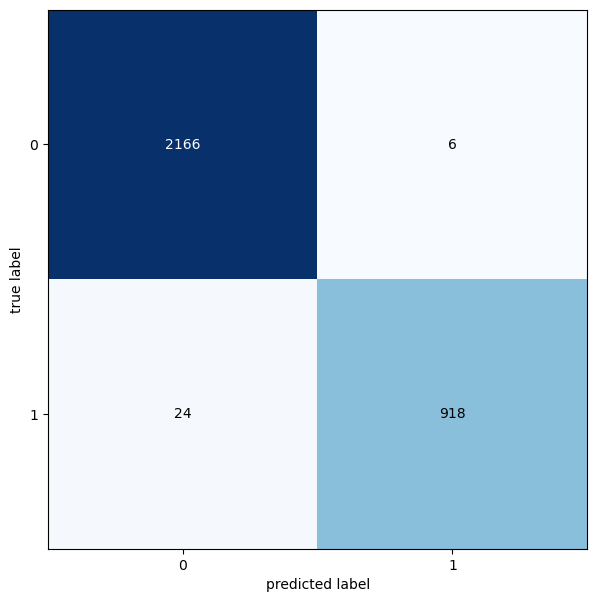

In [693]:
from torchmetrics import ConfusionMatrix, Accuracy, Precision
from mlxtend.plotting import plot_confusion_matrix

model_best.eval()
val_loss, val_performance= 0, 0
with torch.inference_mode():
    X= inputs_tensor_test.to(device)
    y= targets_tensor_test.to(device)

    # Predict for validation data
    val_logits= model_best(X).view(-1)
    sigmoid_output = torch.sigmoid(val_logits)
    val_pred = (sigmoid_output > TRAINING_THRESHOLD).float()
    
    # Calculate loss/performance(accuracy|precision)
    val_loss+= loss_fn(val_logits, y)
    val_performance+= performance_fn(val_pred, y)

print(f"Validation loss: {val_loss:.5f} Performance {PERFORMANCE_MEASURE}: {val_performance*100:.7f}%")

confmat= ConfusionMatrix(task='binary')

# test_data.targets are the values we want to predict in the test dataloader
confmat_tensor= confmat(
  preds= val_pred.cpu(),
  target= targets_tensor_test.cpu())

# Plot confusion matrix
fig, ax= plot_confusion_matrix(
  conf_mat= confmat_tensor.numpy(),
  figsize= (10, 7)
)

accuracy_fn= Accuracy(task='binary').to(device)
val_accuracy = accuracy_fn(val_pred, y)
print(f"Train validation confusion matrix:\n{confmat_tensor}")

precision_fn= Precision(task='binary').to(device)
val_precision = precision_fn(val_pred, y)
print(f"Train validation accuracy: {val_accuracy*100:.2f}%")
print(f"Train validation precision: {val_precision*100:.2f}%")
false_positives = confmat_tensor[0, 1].item()
true_positives = confmat_tensor[1, 1].item()
print(f"Train validation false_positives: {false_positives} true_positives: {true_positives}")

#### Summary

In [695]:
import utils.text_utils as tu

date_start= df['date'][0]
date_end= df['date'].iloc[-1]

target= "UP" if PREDICT_UP else "DOWN"
MODEL_NAME= f"{datetime.now().strftime('%Y-%m-%d-%H%M')}-{TICKER}-predict{target}-dates{tu.shorten_date(date_start)}-{tu.shorten_date(date_end)}-days{DAYS_PREDICT}-down{int(DOWN_PCTS_PREDICT[0]*100)}-up{int(UP_PCTS_PREDICT[0]*100)}-in{len(signal_avg)}-hid{HIDDEN_UNITS}-pos_weight{pos_weight*10000:.0f}-{PERFORMANCE_MEASURE}{val_performance*10000:.0f}pct-fp{false_positives}tp{true_positives}-{best_model_keep}.pth"

print("======TRAINING:")
print(f"Ticker: {TICKER}")

print("--Data")
print(f"Start: {date_start} End: {date_end}")
print(f"Interval: {DATA_INTERVAL_MINUTES} - After Hours: {DATA_AFTER_HOURS}")
print("Targets Frequencies:")
lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

print(f"Signal Averages: {signal_avg}")
print(f"Train predict {'UP' if PREDICT_UP else 'DOWN'} - Days: {DAYS_PREDICT} Down pcts: {DOWN_PCTS_PREDICT} Up pcts: {UP_PCTS_PREDICT}")

print("Training dataset frequencies:")
lu.display_frequency_values(targets_tensor_train.tolist())
print("Validation dataset frequencies:")
lu.display_frequency_values(targets_tensor_test.tolist())

print("--Training")
print(f"Network hidden units: {HIDDEN_UNITS}")
print(f"Loss func: {loss_fn.__class__.__name__}")
print(f"Train negative: {num_zeros} positive: {num_ones} pos_weight: {pos_weight}")
print(f"Optimizer: {optimizer.__class__.__name__} Scheduler: {scheduler.__class__.__name__}")
print(f"Train/Val split: {TRAIN_SPLIT}")
print(f"Train threshold: {TRAINING_THRESHOLD}")
print(f"Epochs: {EPOCHS} learning_rate: {LEARNING_RATE}")

print("--Validation Results")
print(f"Trained model: {MODEL_NAME}")
print(f"Validation loss: {val_loss:.5f} Performance {PERFORMANCE_MEASURE}: {val_performance*100:.2f}%")
print(f"Train validation confusion matrix:\n{confmat_tensor}")
print(f"Train validation accuracy: {val_accuracy*100:.2f}%")
print(f"Train validation precision: {val_precision*100:.2f}%")
print(f"Train validation false_positives: {false_positives} true_positives: {true_positives}")


======TRAINING:
Ticker: TDOC
--Data
Start: 2019-01-02 09:30:00-05:00 End: 2023-12-29 15:45:00-05:00
Interval: 15 - After Hours: False
Targets Frequencies:
Total: 31139
 30.05%   9357 times -3.0% change (0)
 41.29%  12858 times   0% change (1)
 28.66%   8924 times 3.0% change (2)
Signal Averages: [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]
Train predict DOWN - Days: 3 Down pcts: [3.0] Up pcts: [3.0]
Training dataset frequencies:
Total: 28025
 69.97%  19610 times (0.0)
 30.03%   8415 times (1.0)
Validation dataset frequencies:
Total: 3114
 69.75%   2172 times (0.0)
 30.25%    942 times (1.0)
--Training
Network hidden units: 12
Loss func: BCEWithLogitsLoss
Train negative: 19610 positive: 8415 pos_weight: 2.330362558364868
Optimizer: SGD Scheduler: ReduceLROnPlateau
Train/Val split: 0.9
Train threshold: 0.7
Epochs: 1000 learning_rate: 0.1
--Validation Results
Trained model: 2024-05-22-1808-TDOC-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid12-pos_

In [696]:
# Saves model.state_dic() with best performance to a file

from pathlib import Path

# Create directory, if it doesn't exist, to store models
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create path to the model
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# torch.save(
#   obj=model_0.state_dict(),
#   f=f"{MODEL_SAVE_PATH}.pth")

torch.save(
    obj=model_best.state_dict(), 
    f=f"{MODEL_SAVE_PATH}")


print(f"Trained model saved: {MODEL_NAME}")

Trained model saved: 2024-05-22-1808-TDOC-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid12-pos_weight23304-prec9935pct-fp6tp918-high_prec.pth


In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary  


In [ ]:
summary(model_0, input_size=[len(signal_avg)])